# ***Dimensionality Reduction for Political Voting Data***

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
from scipy.spatial import procrustes

## Data acquisition and processing

### Data acquisition

In [3]:
# reading the dataset
df = pd.read_excel("data/EP9.xlsx")

### Data processing

In [4]:
df.head()

,WebisteEpID,Fname,Lname,FullName,Activ,Country,Party,EPG,Start,End,...,13450,13451,13452,13453,13454,13455,13456,13457,13458,13459
0,197490,Magdalena,ADAMOWICZ,"ADAMOWICZ, Magdalena",yes,Poland,Independent,EPP,2019-07-02,2024-12-31,...,2,2,2,1,1,2,1,2,1,1
1,189525,Asim,ADEMOV,"ADEMOV, Asim",yes,Bulgaria,Citizens for European Development of Bulgaria,EPP,2019-07-02,2024-12-31,...,2,2,2,1,2,2,1,2,1,1
2,124831,Isabella,ADINOLFI,"ADINOLFI, Isabella",yes,Italy,Forza Italia,EPP,2019-07-02,2024-12-31,...,2,2,2,1,2,2,1,2,1,1
3,197826,Matteo,ADINOLFI,"ADINOLFI, Matteo",yes,Italy,Lega,IDG,2019-07-02,2024-12-31,...,2,2,1,2,2,1,1,3,2,1
4,197403,Alex,AGIUS SALIBA,"AGIUS SALIBA, Alex",yes,Malta,Partit Laburista,S&D,2019-07-02,2024-12-31,...,3,3,1,2,2,2,3,3,2,1


In [175]:
def process_data(df):
    # remove non activ MEPs
    if 'Activ' in df.columns:
        df = df[df['Activ'] == 'yes']
    
    # remove useless columns
    selected_rows = df.iloc[:, [0, 5, 7]] # ID, Country, EPG
    votes = df.iloc[:, 12:] # votes
    df_processed = pd.concat([selected_rows, votes], axis=1)
    
    # mapping values for similarity computation
    df_processed.iloc[:, 3:] = df_processed.iloc[:, 3:].apply(lambda col: col.map(lambda x: 0 if x in [3, 4, 5, 6, None] else (-1 if x == 2 else x)))

    # remove possibly remaining inactiv MEPs (for EP7 and EP8)
    df_processed = df_processed[~(df_processed.iloc[:, 3:].eq(0).all(axis=1))]
    return df_processed

In [6]:
df_processed = process_data(df)
df_processed.head()

,WebisteEpID,Country,EPG,3,4,5,6,7,8,9,...,13450,13451,13452,13453,13454,13455,13456,13457,13458,13459
0,197490,Poland,EPP,1,-1,-1,1,1,1,1,...,-1,-1,-1,1,1,-1,1,-1,1,1
1,189525,Bulgaria,EPP,1,1,1,1,1,1,1,...,-1,-1,-1,1,-1,-1,1,-1,1,1
2,124831,Italy,EPP,0,0,0,1,-1,1,-1,...,-1,-1,-1,1,-1,-1,1,-1,1,1
3,197826,Italy,IDG,-1,-1,-1,-1,-1,1,1,...,-1,-1,1,-1,-1,1,1,0,-1,1
4,197403,Malta,S&D,1,1,1,-1,-1,1,1,...,0,0,1,-1,-1,-1,0,0,-1,1


### Similarity matrix

In [60]:
def compute_similarity_matrix(df):
    # extract votes part of the dataframe and convert to numpy
    data = df.iloc[:, 3:].to_numpy()
    
    # precompute the norms of each vector
    norms = np.linalg.norm(data, axis=1)
    
    # precompute the dot product between all pairs of vectors
    dot_product = np.dot(data, data.T)
    
    # normalize the dot product to get cosine similarity
    S = dot_product / (norms[:, None] * norms[None, :])
    return S

In [123]:
S = compute_similarity_matrix(df_processed)

<Axes: >

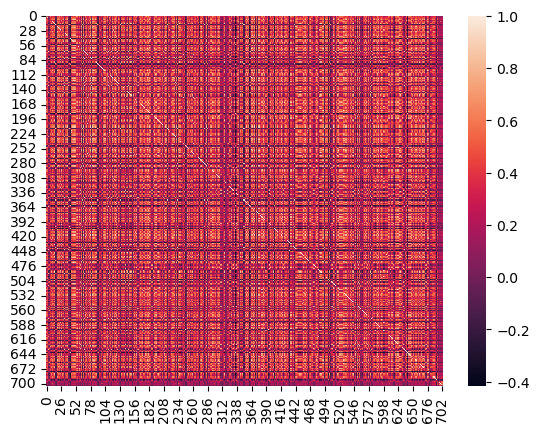

In [124]:
sns.heatmap(S)

## Multidimensional Scaling

In [68]:
def MDS(S, K):
    # eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eig(S)

    # sort eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # choose the top K eigenvectors and eigenvalues
    eigenvalues = np.diag(np.sqrt(eigenvalues[:K]))
    eigenvectors = eigenvectors[:, :K]
    
    # compute the coordinates of the points in the lower dimensional space
    X = eigenvectors @ eigenvalues
    return X

In [188]:
def plot_low_dimension(X, N_samples):
    # generate random indices to plot randomly selected data points
    random_indices = [random.randint(0, len(X)-1) for _ in range(N_samples)]
    # select the data points to plot and the corresponding colors
    X = X[random_indices]
    colors = df_processed.iloc[random_indices,1:3]
    # plot
    for i in range(len(X)):
        # plot data points
        plt.scatter(X[i][0], X[i][1])
        # annotate country
        plt.annotate(colors.iloc[i, 0], (X[i][0], X[i][1]), textcoords="offset points", xytext=(0, 9), ha='center', fontsize=5)
        # annotate EPG
        plt.annotate(colors.iloc[i, 1], (X[i][0], X[i][1]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=5) 
    plt.title(f"MDS embeddings of {N_samples} MEPs in 2D space")
    plt.show()

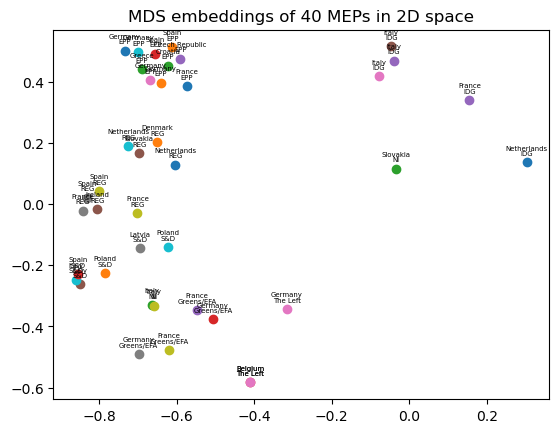

In [191]:
N_samples = 40
X = MDS(S, 2)
plot_low_dimension(X, N_samples)

## Explorative data analysis

### Data acquisition

In [529]:
# reading the datasets
df_1 = pd.read_excel("data/EP6.xlsx")
df_2 = pd.read_excel("data/EP7.xlsx")
df_3 = pd.read_excel("data/EP8.xlsx")
df_4 = pd.read_excel("data/EP9.xlsx")

### Data processing

1 - Uniformize the three datasets

In [530]:
print('df_1',df_1.head())
print('df_2',df_2.head())
print('df_3',df_3.head())
print('df_4',df_4.head())

df_1        Column2     Column3    Column4              Column5 Column6  Column7  \
0  WebisteEpID       Fname      Lname             FullName   Activ  Country   
1          NaN         NaN        NaN                  NaN     NaN      NaN   
2        28469     Adamos      ADAMOU       ADAMOU, Adamos     yes   Cyprus   
3        28302      Filip      ADWENT        ADWENT, Filip      no   Poland   
4        28975   Vittorio   AGNOLETTO  AGNOLETTO, Vittorio     yes    Italy   

                                             Column8  \
0                                              Party   
1                                                NaN   
2  Anorthotiko Komma Ergazomenou Laou - Aristera ...   
3                               Liga Polskich Rodzin   
4  Partito della Rifondazione Comunista - Sinistr...   

                                             Column9    Column10    Column11  \
0                                                EPG       Start         End   
1                      

In [531]:
# change columns' names in EP6
new_col = df_1.iloc[0]
df_1.columns = new_col 
# remove the row
df_1 = df_1[1:].reset_index(drop=True)

df_1.head()

,WebisteEpID,Fname,Lname,FullName,Activ,Country,Party,EPG,Start,End,...,6191.0,6192.0,6193.0,6194.0,6195.0,6196.0,6197.0,6198.0,6199.0,6200.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28469,Adamos,ADAMOU,"ADAMOU, Adamos",yes,Cyprus,Anorthotiko Komma Ergazomenou Laou - Aristera ...,Confederal Group of the European United Left -...,2004-07-20,2009-12-31,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,28302,Filip,ADWENT,"ADWENT, Filip",no,Poland,Liga Polskich Rodzin,Independence/Democracy Group,2004-07-20,2005-06-26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28975,Vittorio,AGNOLETTO,"AGNOLETTO, Vittorio",yes,Italy,Partito della Rifondazione Comunista - Sinistr...,Confederal Group of the European United Left -...,2004-07-20,2009-12-31,...,2.0,3.0,1.0,2.0,1.0,2.0,5.0,2.0,5.0,5.0
4,28367,Gabriele,ALBERTINI,"ALBERTINI, Gabriele",yes,Italy,Forza Italia,Group of the European People's Party (Christia...,2004-07-20,2009-12-31,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,5.0,5.0


In [532]:
# replace EPG in EP7
df_2[['EPG', 'Start']] = df_2[['Start', 'EPG']]
df_2.head()

,MEP ID,Fname,Lname,FullName,Country,Party,EPG,Start,End,1,...,6954,6955,6956,6957,6958,6959,6960,6961,6962,6963
0,1,Damien,ABAD,"ABAD, Damien",France,Nouveau Centre,2009-07-14,Group of the European People's Party (Christia...,2012-06-16,2,...,0,0,0,0,0,0,0,0,0,0
1,2,János,ÁDER,"ÁDER, János",Hungary,Fidesz-Magyar Polgári Szövetség-Keresztény Dem...,2009-07-14,Group of the European People's Party (Christia...,2012-05-09,2,...,0,0,0,0,0,0,0,0,0,0
2,3,John Stuart,AGNEW,"AGNEW, John Stuart",United Kingdom,United Kingdom Independence Party,2009-07-14,Europe of freedom and democracy Group,2014-12-31,5,...,3,2,1,3,2,1,3,3,1,5
3,4,Gabriele,ALBERTINI,"ALBERTINI, Gabriele",Italy,Il Popolo della Libertà,2009-07-14,Group of the European People's Party (Christia...,2013-03-14,2,...,0,0,0,0,0,0,0,0,0,0
4,5,Jan Philipp,ALBRECHT,"ALBRECHT, Jan Philipp",Germany,Bündnis 90/Die Grünen,2009-07-14,Group of the Greens/European Free Alliance,2014-12-31,5,...,4,4,4,4,4,4,4,4,4,4


In [533]:
# replace EPG in EP8
df_3[['EPG', 'Start']] = df_3[['Start', 'EPG']]
df_3.head()

,WebisteEpID,Fname,Lname,Activ,Country,Party,EPG,Start,End,1,...,10267,10268,10269,10270,10271,10272,10273,10274,10275,10276
0,124990,Lars,ADAKTUSSON,no,Sweden,Kristdemokraterna,2014-07-01,NaN,2018-09-23,5,...,0,0,0,0,0,0,0,0,0,0
1,124831,Isabella,ADINOLFI,yes,Italy,Movimento 5 Stelle,2014-07-01,Europe of Freedom and Direct Democracy Group,2019-12-31,5,...,4,4,4,4,4,4,4,4,4,4
2,124797,Marco,AFFRONTE,yes,Italy,Independent,2014-07-01,Group of the Greens/European Free Alliance,2019-12-31,2,...,3,1,1,5,5,5,5,5,5,5
3,124811,Laura,AGEA,yes,Italy,Movimento 5 Stelle,2014-07-01,Europe of Freedom and Direct Democracy Group,2019-12-31,5,...,1,3,3,3,1,1,1,1,1,1
4,96897,John Stuart,AGNEW,yes,United Kingdom,United Kingdom Independence Party,2014-07-01,Europe of Freedom and Direct Democracy Group,2019-12-31,2,...,4,4,4,4,4,4,4,4,4,4


2 - Process the three datasets for similarity computation

In [535]:
df_1_processed = process_data(df_1)
df_2_processed = process_data(df_2)
df_3_processed = process_data(df_3)
df_4_processed = process_data(df_4)

3 - Handle the evolution of EPG's names to ensure time coherence

In [536]:
# print unique EPGs for each EP
unique_EPG_1 = df_1_processed.iloc[:,2].unique()
print("Unique EPGs in EP6:", unique_EPG_1)
unique_EPG_2 = df_2_processed.iloc[:,2].unique()
print("Unique EPGs in EP7:", unique_EPG_2)
unique_EPG_3 = df_3_processed.iloc[:,2].unique()
print("Unique EPGs in EP8:", unique_EPG_3)
unique_EPG_4 = df_4_processed.iloc[:,2].unique()
print("Unique EPGs in EP9:", unique_EPG_4)

Unique EPGs in EP6: ['Confederal Group of the European United Left - Nordic Green Left'
 "Group of the European People's Party (Christian Democrats) and European Democrats"
 'Non-attached Members'
 'Group of the Alliance of Liberals and Democrats for Europe'
 'Socialist Group in the European Parliament'
 'Union for Europe of the Nations Group'
 'Group of the Greens/European Free Alliance'
 'Independence/Democracy Group']
Unique EPGs in EP7: ["Group of the European People's Party (Christian Democrats)"
 'Europe of freedom and democracy Group'
 'Group of the Greens/European Free Alliance'
 'Group of the Alliance of Liberals and Democrats for Europe'
 'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament'
 'European Conservatives and Reformists Group' 'Non-attached Members'
 'Confederal Group of the European United Left - Nordic Green Left']
Unique EPGs in EP8: ['Europe of Freedom and Direct Democracy Group'
 'Group of the Greens/European Free Alliance'

In [537]:
# map old names to new ones with a dictionnary
epg_mapping = {
    "Confederal Group of the European United Left - Nordic Green Left": "The Left",
    "Group of the European People's Party (Christian Democrats) and European Democrats": "EPP",
    "Group of the European People's Party (Christian Democrats)": "EPP",
    "Non-attached Members": "NI",
    "Group of the Alliance of Liberals and Democrats for Europe": "REG",
    "Socialist Group in the European Parliament": "S&D",
    "Union for Europe of the Nations Group": None,  # removed
    "Group of the Greens/European Free Alliance": "Greens/EFA",
    "Independence/Democracy Group": None,  # removed
    "Europe of freedom and democracy Group": "IDG",
    "Group of the Progressive Alliance of Socialists and Democrats in the European Parliament": "S&D",
    "European Conservatives and Reformists Group": "ECR",
    "Europe of Freedom and Direct Democracy Group": "IDG",
    "Europe of Nations and Freedom Group": "IDG"
}

# replace EPG names in each df according to the mapping
df_1_processed.iloc[:, 2] = df_1_processed.iloc[:, 2].replace(epg_mapping)
df_2_processed.iloc[:, 2] = df_2_processed.iloc[:, 2].replace(epg_mapping)
df_3_processed.iloc[:, 2] = df_3_processed.iloc[:, 2].replace(epg_mapping)
df_4_processed.iloc[:, 2] = df_4_processed.iloc[:, 2].replace(epg_mapping)

# remove groups that have disappeared
df_1_processed = df_1_processed[df_1_processed.iloc[:, 2].notna()]
df_2_processed = df_2_processed[df_2_processed.iloc[:, 2].notna()]
df_3_processed = df_3_processed[df_3_processed.iloc[:, 2].notna()]
df_4_processed = df_4_processed[df_4_processed.iloc[:, 2].notna()]

# display the updated DataFrames (you can check the first few rows to confirm)
print("Updated df_1 (EP6):")
print(df_1_processed.head())
print("\nUpdated df_2 (EP7):")
print(df_2_processed.head())
print("\nUpdated df_3 (EP8):")
print(df_3_processed.head())
print("\nUpdated df_4 (EP9):")
print(df_4_processed.head())

Updated df_1 (EP6):
0 WebisteEpID         Country       EPG  3.0  4.0  5.0  6.0  7.0  8.0  9.0  \
1       28469          Cyprus  The Left  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3       28975           Italy  The Left  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4       28367           Italy       EPP  1.0  1.0  1.0  1.0  0.0  1.0  1.0   
5       28512  United Kingdom        NI -1.0 -1.0 -1.0 -1.0  0.0  0.0  0.0   
6       28246         Germany       REG  0.0  0.0 -1.0  0.0  1.0  1.0  1.0   

0  ...  6191.0  6192.0  6193.0  6194.0  6195.0  6196.0  6197.0  6198.0  \
1  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3  ...    -1.0     0.0     1.0    -1.0     1.0    -1.0     0.0    -1.0   
4  ...     1.0     1.0     1.0     1.0    -1.0     1.0     1.0     0.0   
5  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6  ...     1.0     1.0     1.0     1.0    -1.0     1.0     1.0     0.0   

0  6199.0  6200.0  
1     0.0     0.0  
3     0.0     0.0  
4     

4 - Sort by EPG for Procrustes analysis

In [538]:
dfs = [df_1_processed, df_2_processed, df_3_processed, df_4_processed]

# get common EPGs over all dfs
common_epgs = set(dfs[0].iloc[:, 2])
for df in dfs[1:]:
    common_epgs.intersection_update(set(df.iloc[:, 2]))

print(f"Common EPGs : {common_epgs}")

# filter the dfs to keep only common EPGs
filtered_dfs = []
for df in dfs:
    filtered_df = df[df.iloc[:, 2].isin(common_epgs)]
    filtered_dfs.append(filtered_df)

# sort and extract an identical instances of each EPG
sorted_filtered_dfs = []

for df in filtered_dfs:
    # sort the EPG column
    df_sorted = df.sort_values(by=df.columns[2])
    
    new_df = pd.DataFrame()
    
    # extract
    for epg in common_epgs:
        if epg == "NI":
            # only ten fdr "NI"
            epg_data = df_sorted[df_sorted.iloc[:, 2] == epg].head(20)
        else:
            # 39 for the others
            epg_data = df_sorted[df_sorted.iloc[:, 2] == epg].head(39)
        new_df = pd.concat([new_df, epg_data], ignore_index=True)
    
    sorted_filtered_dfs.append(new_df)

df_1_new, df_2_new, df_3_new, df_4_new = sorted_filtered_dfs

# check the sizes
sizes = [len(df) for df in sorted_filtered_dfs]
print(f"DataFrame sizes : {sizes}")

Common EPGs : {'Greens/EFA', 'EPP', 'REG', 'S&D', 'NI', 'The Left'}
DataFrame sizes : [215, 215, 215, 215]


### Similarity matrices

In [539]:
S_1 = compute_similarity_matrix(df_1_new)
S_2 = compute_similarity_matrix(df_2_new)
S_3 = compute_similarity_matrix(df_3_new)
S_4 = compute_similarity_matrix(df_4_new)

### MDS embedding

In [540]:
X_1 = MDS(S_1, 2)
X_2 = MDS(S_2, 2)
X_3 = MDS(S_3, 2)
X_4 = MDS(S_4, 2)

### Procrustes analysis to align embeddings

In [541]:
# align the embeddings based on a reference
embeddings = [X_1, X_2, X_3, X_4]
reference = embeddings[0]  # choose EP6 as the reference

aligned_embeddings = [reference]
for i in range(1, len(embeddings)):
    _, aligned, _ = procrustes(reference, embeddings[i])
    aligned_embeddings.append(aligned)

### Plotting

In [542]:
def plot_EPG(X_EPG, color, label):
    # convert to numpy
    X_EPG = np.array(X_EPG)
    
    # plot the data points
    plt.scatter(X_EPG[:, 0], X_EPG[:, 1], c=color, label=label)

In [543]:
def plot_low_dimension_EPG(X, df, date):
    # reinitialize indices
    df_reset = df.reset_index(drop=True)
    # select and plot for each unique EPG
    unique_EPG =  df_reset.iloc[:,2].unique()
    for epg in unique_EPG:
        indices_EPG = df_reset[df_reset.iloc[:,2] == epg].index.tolist()
        X_EPG = X[indices_EPG]
        
        # plot
        if epg == 'The Left':
            plot_EPG(X_EPG, color = 'red', label = epg)
        if epg == 'S&D':
            plot_EPG(X_EPG, color = 'orange', label = epg)
        elif epg == 'Greens/EFA':
            plot_EPG(X_EPG, color = 'green', label = epg)
        if epg == 'REG':
            plot_EPG(X_EPG, color = '#ADD8E6', label = epg)
        if epg == 'EPP':
            plot_EPG(X_EPG, color = '#0000CD', label = epg)
        if epg == 'IDG':
            plot_EPG(X_EPG, color = '#00008B', label = epg)
        if epg == 'NI':
            plot_EPG(X_EPG, color = 'grey', label = epg)
    plt.legend()
    plt.title(f"MDS embeddings of MEPs on {date} period")
    plt.grid()
    plt.show()

In [544]:
def plot_EPG_centroids(X_EPG, color, label):
    # convert to numpy
    X_EPG = np.array(X_EPG)
    
    # compute spatial mean
    x_bar = np.mean(X_EPG[:, 0])
    y_bar = np.mean(X_EPG[:, 1])
    
    # plot the centroid
    plt.scatter(x_bar, y_bar, c=color, label=label)

In [545]:
def plot_low_dimension_EPG_centroids(X, df, date):
    # reinitialize indices
    df_reset = df.reset_index(drop=True)
    # select and plot for each unique EPG
    unique_EPG =  df_reset.iloc[:,2].unique()
    for epg in unique_EPG:
        indices_EPG = df[df.iloc[:,2] == epg].index.tolist()
        X_EPG = X[indices_EPG]
        
        # plot
        if epg == 'The Left':
            plot_EPG_centroids(X_EPG, color = 'red', label = epg)
        if epg == 'S&D':
            plot_EPG_centroids(X_EPG, color = 'orange', label = epg)
        elif epg == 'Greens/EFA':
            plot_EPG_centroids(X_EPG, color = 'green', label = epg)
        if epg == 'REG':
            plot_EPG_centroids(X_EPG, color = '#ADD8E6', label = epg)
        if epg == 'EPP':
            plot_EPG_centroids(X_EPG, color = '#0000CD', label = epg)
        if epg == 'IDG':
            plot_EPG_centroids(X_EPG, color = '#00008B', label = epg)
        if epg == 'NI':
            plot_EPG_centroids(X_EPG, color = 'grey', label = epg)
    plt.legend()
    plt.title(f"Average MDS embeddings of MEPs on {date} period")
    plt.grid()
    plt.show()

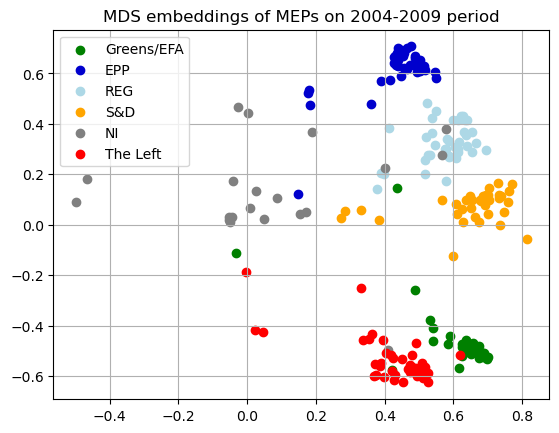

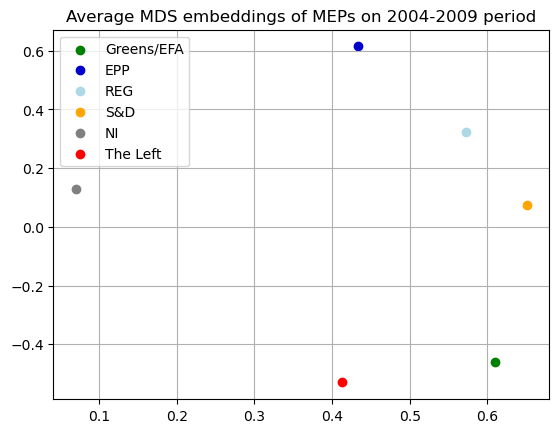

In [546]:
X_1_aligned = aligned_embeddings[0]
plot_low_dimension_EPG(X_1_aligned, df_1_new, "2004-2009")
plot_low_dimension_EPG_centroids(X_1_aligned, df_1_new, "2004-2009")

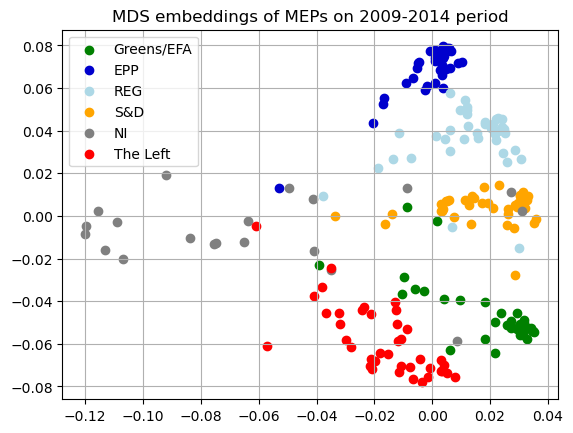

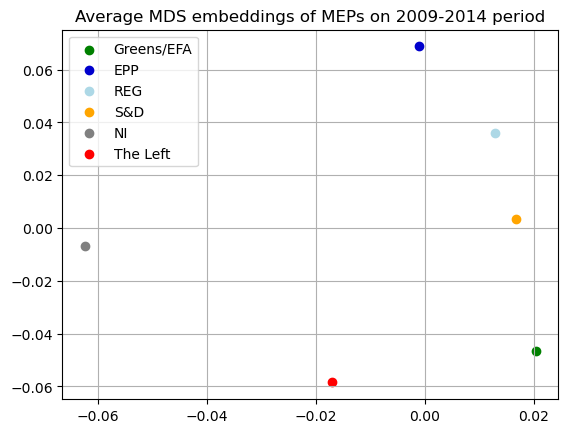

In [547]:
X_2_aligned = aligned_embeddings[1]
plot_low_dimension_EPG(X_2_aligned, df_2_new, "2009-2014")
plot_low_dimension_EPG_centroids(X_2_aligned, df_2_new, "2009-2014")

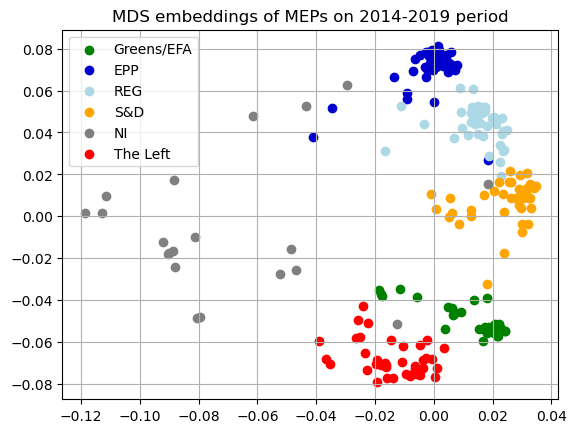

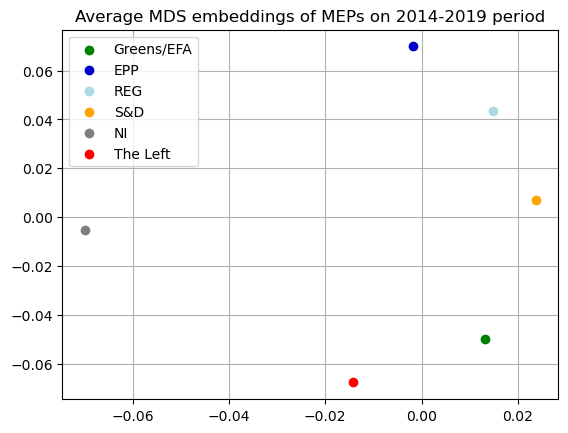

In [548]:
X_3_aligned = aligned_embeddings[2]
plot_low_dimension_EPG(X_3_aligned, df_3_new, "2014-2019")
plot_low_dimension_EPG_centroids(X_3_aligned, df_3_new, "2014-2019")

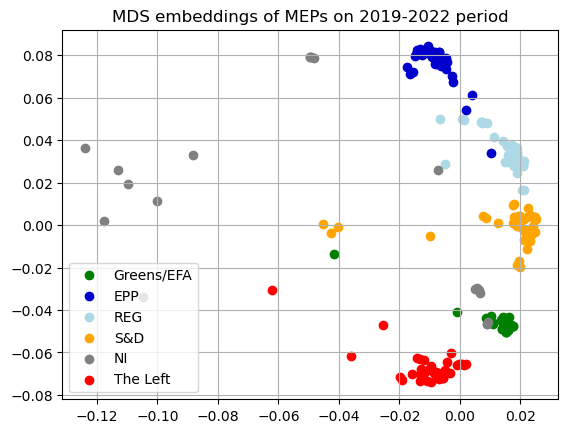

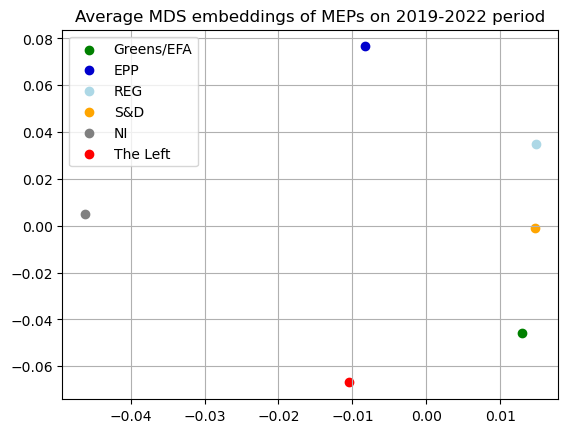

In [549]:
X_4_aligned = aligned_embeddings[3]
plot_low_dimension_EPG(X_4_aligned, df_4_new, "2019-2022")
plot_low_dimension_EPG_centroids(X_4_aligned, df_4_new, "2019-2022")